## Calculate poleward heat transport as inferred by TOA and surface fluxes

Net TOA and net surface fluxes have already been calculated elsewhere. <br>
Here we read in numpy data files and integrate the fluxes from pole to pole to get PHT (calculated in another class). <br>

#### The purpose of the notebook is to test various ways to remove the residual transport at the pole.<br>

Total PHT = integral[TOA fluxes out to space] <br>
Ocean PHT = integral[surface fluxes out of ocean] <br>
Atmos PHT = Total - Ocean.
<br><br>


### Configure settings and initialize

In [8]:
import energybalance_utils as ebu
import loadCanESM2rlxdata as lrlx
import pandas as pd

#import constants as con
#con=reload(con)

%matplotlib inline

domonth=False
sea='ANN'
mo=1 # mo is 1-based
last='last200' # else 'last100', 'first100'
includeyr1=False # only used when first100

suff = last+'yr'
if domonth:
    seasonalizedt={'mo':mo}
else:
    seasonalizedt={'season':sea}

if last=='last200': fldsfx='NH'

zconv = 1/con.get_g()


casenames = ('preipreiice', 'prei2xco2iceb','pi2xco2ipulse', '2xco22xco2ice','2xco2preiice')
shortnames = {'preipreiice': '1C_1I',
             'prei2xco2iceb': '1C_2I',
             'pi2xco2ipulse': '1C_2Ipulse',
             '2xco22xco2ice': '2C_2I',
             '2xco2preiice': '2C_1I'}

colors = {'preipreiice': 'k', 'prei2xco2iceb': 'b', 
            'pi2xco2ipulse': 'cyan', '2xco22xco2ice': 'r',
            '2xco2preiice': 'pink'}

verb=False

lat,lon = lrlx.load_nclatlon('st'+fldsfx,last=last,includeyr1=includeyr1,verb=verb)

### Read in the data

In [6]:
fluxkeys = ('nettoa','netsfc')
timepers, timesels =lrlx.get_timeinfo(last=last) 
timepers['piControl'] = '2015-3010'
timepers['gregory_2xco2'] = '2451-2550'

# get global lat for PHT vars
glat,glon = lrlx.load_nclatlon('st',last='last100',
                               includeyr1=includeyr1,verb=True)

matdir = '/HOME/rkm/pyscripts/pymatfiles/'
#npydir = '/HOME/rkm/pyscripts/pynpyfiles/'
npydir = '/Users/kelly/pyscripts/pynpyfiles/'
ttype='timeseries'


# First load the data from .mat files
allflux={}; allfluxtm={}
totpht={}; ocnpht={}; atmpht={}
totphtadjtm={}; totphtnhadjtm={}; totphtshadjtm={}; totphthemadjtm={}; tot60adjtm={}

totphttm={}; ocnphttm={}; atmphttm={}
netimbal={}; nhnetimbal={}; shnetimbal={}; adjnetimbal={}
nhimbaltile={}; nhadjnetimbal={}; shimbaltile={}; shadjnetimbal={}
hemimbaltile={}; hemadjnetimbal={}
n60netimbal={}; s60netimbal={}; imbal60tile={}; adj60netimbal={}

gweights = np.cos(np.deg2rad(glat))

# For each simulation, load the npy file with nettoa, netsfc data
for casename in casenames+('piControl','gregory_2xco2'):
    timeper = timepers[casename]
    
    fluxdt={}; fluxtmdt={}
        
    for fkey in fluxkeys:
        matname = npydir + 'PHT/' + fkey + '_' + casename + '_' + \
               sea + '_' + ttype + timeper +'.npy'
        print 'load ' + matname
        print casename,fkey

        tmp = np.load(matname)
        print tmp.shape
        
        # save the zonal mean fluxes with and without time
        fluxdt[fkey] = tmp # keep time dim
        fluxtmdt[fkey]  = tmp.mean(axis=0) # time mean
        
        # If loading nettoa, test out some methods of adjusting for residual non-zero imbalance
        if fkey=='nettoa':
            print '@@@@ ' + str(fluxtmdt[fkey].shape)
            
            # ==== Compute global, hemispheric, and North polar averages of the TOA fluxes =========
            
            # compute the global average net TOA imbalance
            netimbal[casename] = np.average(fluxtmdt[fkey],weights=gweights)
            # compute the NH average net TOA imbalance
            nhnetimbal[casename] = np.average(fluxtmdt[fkey][glat>0],weights=np.cos(np.deg2rad(glat[glat>0])))
            # compute the SH average net TOA imbalance
            shnetimbal[casename] = np.average(fluxtmdt[fkey][glat<0],weights=np.cos(np.deg2rad(glat[glat<0])))
            # compute the net TOA imbalance north of 60N 
            n60netimbal[casename] = np.average(fluxtmdt[fkey][glat>60],weights=np.cos(np.deg2rad(glat[glat>60])))
            # compute the net TOA imbalance south of 60 NORTH
            s60netimbal[casename] = np.average(fluxtmdt[fkey][glat<=60],weights=np.cos(np.deg2rad(glat[glat<=60])))

            # ==== Make adjustments to the net TOA fluxes to attempt to remove "residual" flux ========

            # Adjustment #1
            # Net TOA flux with the GLOBAL average net imbalance removed
            adjnetimbal[casename] = np.average(fluxtmdt[fkey]-netimbal[casename],weights=np.cos(np.deg2rad(glat)))
            
            # Adjustment #2
            # Net TOA flux with just the NH average net imbalance removed from the NH          
            ntmp = np.tile(nhnetimbal[casename],fluxtmdt[fkey].shape)
            ntmp[glat<0] = 0 # no corrections in the SH
            nhimbaltile[casename] = ntmp
            nhadjnetimbal[casename] = np.average(fluxtmdt[fkey]-nhimbaltile[casename],
                                                 weights=np.cos(np.deg2rad(glat)))
            # Adjustment #3
            # Net TOA flux with just the SH average net imbalance removed from the SH
            stmp = np.tile(shnetimbal[casename],fluxtmdt[fkey].shape)
            stmp[glat>0] = 0 # no corrections in the NH
            shimbaltile[casename] = stmp
            shadjnetimbal[casename] = np.average(fluxtmdt[fkey]-shimbaltile[casename],
                                                 weights=np.cos(np.deg2rad(glat)))            
            # Adjustment #4
            # Net TOA flux with each hemisphere's imbalance removed from each hemisphere, respectively
            htmp = np.tile(nhnetimbal[casename],fluxtmdt[fkey].shape) # start with NH imbalance everywhere
            htmp[glat<0] = stmp[glat<0] # fill in SH imbalance in SH only
            hemimbaltile[casename] = htmp
            hemadjnetimbal[casename] = np.average(fluxtmdt[fkey]-hemimbaltile[casename],
                                                  weights=np.cos(np.deg2rad(glat)))                        
            # Adjustment #5
            # Net TOA flux with south of 60NORTH flux removed south of 60N, and north of 60N imbal removed north of 60N
            tmp60n = np.tile(n60netimbal[casename],fluxtmdt[fkey].shape) 
            tmp60 = np.tile(s60netimbal[casename],fluxtmdt[fkey].shape) # start with south of 60N imbal everywhere
            tmp60[glat>60] = tmp60n[glat>60] # add north of 60N imbal north of 60N only
            imbal60tile[casename] = tmp60
            adj60netimbal[casename] = np.average(fluxtmdt[fkey]-imbal60tile[casename],
                                                  weights=np.cos(np.deg2rad(glat)))
            
        elif fkey=='netsfc' and (casename=='piControl' or casename=='gregory_2xco2'):
            # need to multiply by -1 for these CMIP style (non-nudging) simulations
            fluxdt[fkey] = -1*tmp # keep time dim
            fluxtmdt[fkey]  = -1*tmp.mean(axis=0) # time mean
            
    allflux[casename] = fluxdt
    allfluxtm[casename] = fluxtmdt

    # ===== compute the poleward heat transport: total, ocean, atmos with and without time dim =====
    totpht[casename],ocnpht[casename],atmpht[casename] =\
        ebu.calc_inferred_pht_components(fluxdt['nettoa'],fluxdt['netsfc'],glat)
    totphttm[casename],ocnphttm[casename],atmphttm[casename] =\
        ebu.calc_inferred_pht_components(fluxtmdt['nettoa'],fluxtmdt['netsfc'],glat)
        
    # ===== compute the adjusted transport for just the total component and just time mean
    totphtadjtm[casename] = ebu.calc_inferred_pht(fluxtmdt['nettoa']-netimbal[casename],glat)
    totphtnhadjtm[casename] = ebu.calc_inferred_pht(fluxtmdt['nettoa']-nhimbaltile[casename],glat)
    totphtshadjtm[casename] = ebu.calc_inferred_pht(fluxtmdt['nettoa']-shimbaltile[casename],glat)
    totphthemadjtm[casename] = ebu.calc_inferred_pht(fluxtmdt['nettoa']-hemimbaltile[casename],glat)
    tot60adjtm[casename] = ebu.calc_inferred_pht(fluxtmdt['nettoa']-imbal60tile[casename],glat)

/Volumes/KellyDataDisk/home/work/DATA/CanESM2/preipreiice/ts/preipreiice_st_3022-3121_ts.nc
lat.shape (64,)
lon.shape (129,)
load /Users/kelly/pyscripts/pynpyfiles/PHT/nettoa_preipreiice_ANN_timeseries2922-3121.npy
preipreiice nettoa
(200, 64)
@@@@ (64,)
load /Users/kelly/pyscripts/pynpyfiles/PHT/netsfc_preipreiice_ANN_timeseries2922-3121.npy
preipreiice netsfc
(200, 64)
load /Users/kelly/pyscripts/pynpyfiles/PHT/nettoa_prei2xco2iceb_ANN_timeseries3022-3221.npy
prei2xco2iceb nettoa
(200, 64)
@@@@ (64,)
load /Users/kelly/pyscripts/pynpyfiles/PHT/netsfc_prei2xco2iceb_ANN_timeseries3022-3221.npy
prei2xco2iceb netsfc
(200, 64)
load /Users/kelly/pyscripts/pynpyfiles/PHT/nettoa_pi2xco2ipulse_ANN_timeseries2921-3021.npy
pi2xco2ipulse nettoa
(100, 64)
@@@@ (64,)
load /Users/kelly/pyscripts/pynpyfiles/PHT/netsfc_pi2xco2ipulse_ANN_timeseries2921-3021.npy
pi2xco2ipulse netsfc
(100, 64)
load /Users/kelly/pyscripts/pynpyfiles/PHT/nettoa_2xco22xco2ice_ANN_timeseries2452-2651.npy
2xco22xco2ice nettoa

### Plot Total PHT and variously adjusted Total PHT

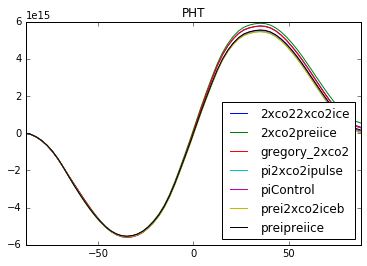

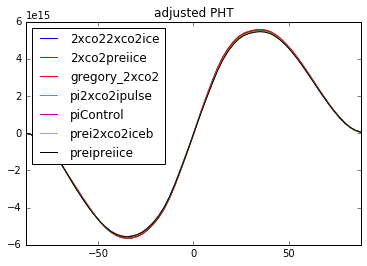

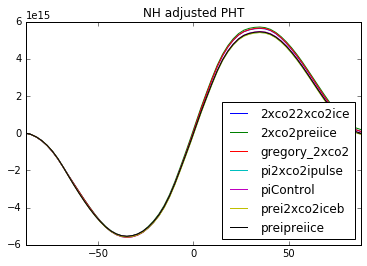

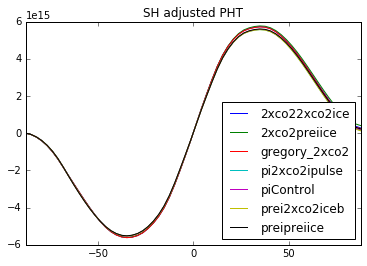

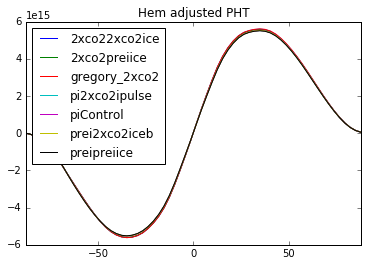

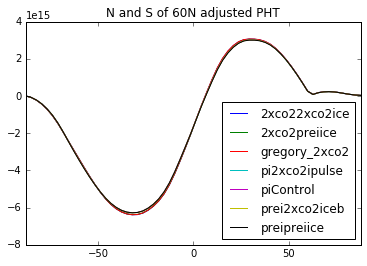

In [9]:
#  These are all TOTAL PHT

# Plot poleward heat transport
totdf = pd.DataFrame(totphttm,index=glat)
totdf.plot(title='PHT')

totadjdf = pd.DataFrame(totphtadjtm,index=glat)
totadjdf.plot(title='adjusted PHT')

# just the NH is adjusted
totnhadjdf = pd.DataFrame(totphtnhadjtm,index=glat)
totnhadjdf.plot(title='NH adjusted PHT')

# just the SH is adjusted
totshadjdf = pd.DataFrame(totphtshadjtm,index=glat)
totshadjdf.plot(title='SH adjusted PHT')

# both Hems separately adjusted
tothemadjdf = pd.DataFrame(totphthemadjtm,index=glat)
tothemadjdf.plot(title='Hem adjusted PHT')

# N and S of 60N separately adjusted
tot60adjdf = pd.DataFrame(tot60adjtm,index=glat)
tot60adjdf.plot(title='N and S of 60N adjusted PHT')




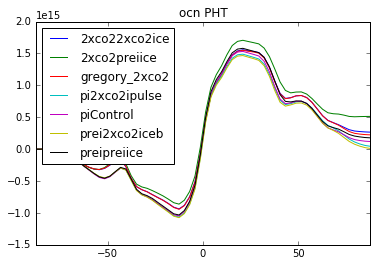

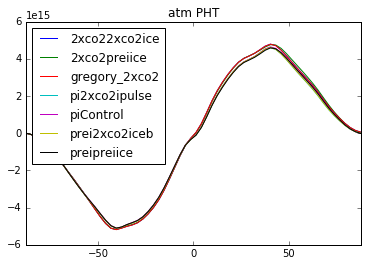

In [10]:
ocndf = pd.DataFrame(ocnphttm,index=glat)
ocndf.plot(title='ocn PHT')
atmdf = pd.DataFrame(atmphttm,index=glat)
atmdf.plot(title='atm PHT')

